## Import Library

In [1]:
from lib import KNN
from lib import NaiveBayes
from lib import GaussianNaiveBayes
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy import stats

## Show Data Statistic

In [2]:
df = pd.read_csv('data_train.csv')

In [3]:
df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,536,1,1.4,0,0,1,53,0.7,135,3,...,547,705,1211,15,10,7,1,0,1,0
1396,1097,0,0.8,0,10,1,21,0.1,160,7,...,1277,1352,2219,15,6,12,1,0,1,2
1397,1179,1,0.5,0,7,1,32,0.3,182,2,...,85,1451,340,16,5,16,1,0,0,0
1398,719,1,0.5,1,0,1,23,0.4,113,6,...,431,1727,3990,14,9,12,1,1,1,3


In [4]:
def descriptive_statistic(df,features):
     ft = []
     mean = []
     median = []
     mode = []
     std_dev = []
     variance = []
     data_range = []
     min_val = []
     max_val = []
     q1 = []
     q3 = []
     iqr = []
     skewness = []
     kurtosis = []
     for feature in features:
          # Inisiasi kolom feature
          df_column = df[feature]
          ft.append(feature)
          
          # Hitung nilai mean
          mean.append(df_column.mean())

          # Hitung nilai median
          median.append(df_column.median())

          # Hitung nilai modus
          mode.append(df_column.mode()[0])

          # Hitung nilai standar deviasi
          std_dev.append(df_column.std())

          # Hitung nilai variansi
          variance.append(df_column.var())

          # Hitung nilai range
          data_range.append(df_column.max() - df_column.min())

          # Hitung nilai minimum
          min_val.append(df_column.min())

          # Hitung nilai maksimum
          max_val.append(df_column.max())

          # Hitung kuartil pertama dan ketiga
          q1.append(np.percentile(df_column, 25))
          q3.append(np.percentile(df_column, 75))

          # Hitung interquartile range (IQR)
          iqr.append(np.percentile(df_column, 75) - np.percentile(df_column, 25))

          # Hitung nilai skewness
          skewness.append(stats.skew(df_column))

          # Hitung nilai kurtosis
          kurtosis.append(stats.kurtosis(df_column))

     return pd.DataFrame({ 'fitur' : ft,
            'mean' : mean,
            'median' : median,
            'modus' : mode,
            'std_dev' : std_dev,
            'variansi' : variance,
            'range' : data_range,
            'min' : min_val,
            'max' : max_val,
            'q1' : q1,
            'q3' : q3,
            'IQR' : iqr,
            'skewness' : skewness,
            'kurtosis' : kurtosis
    }).round(3)

In [5]:
#separate categorical and numerical features
numerical_features = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']
categorical_features = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
target_feature = ['price_range']

In [6]:
desc_stats = descriptive_statistic(df, numerical_features)
desc_stats

,fitur,mean,median,modus,std_dev,variansi,range,min,max,q1,q3,IQR,skewness,kurtosis
0,battery_power,1237.146,1219.0,772.0,430.052,184944.538,1497.0,501.0,1998.0,864.75,1602.00,737.25,0.042,-1.168
1,clock_speed,1.522,1.5,0.5,0.815,0.664,2.5,0.5,3.0,0.70,2.20,1.50,0.166,-1.329
2,fc,4.275,3.0,0.0,4.324,18.698,19.0,0.0,19.0,1.00,7.00,6.00,1.019,0.288
3,int_memory,31.962,32.0,27.0,18.163,329.893,62.0,2.0,64.0,16.00,48.00,32.00,0.063,-1.227
4,m_dep,0.508,0.5,0.1,0.289,0.083,0.9,0.1,1.0,0.20,0.80,0.60,0.059,-1.267
5,mobile_wt,139.376,139.0,182.0,35.401,1253.217,120.0,80.0,200.0,108.00,169.00,61.00,0.020,-1.210
6,n_cores,4.481,4.0,4.0,2.280,5.198,7.0,1.0,8.0,2.00,7.00,5.00,0.020,-1.232
7,pc,9.917,10.0,10.0,6.080,36.967,20.0,0.0,20.0,5.00,15.00,10.00,0.029,-1.164
8,px_height,643.178,561.0,88.0,444.629,197694.930,1960.0,0.0,1960.0,273.75,950.25,676.50,0.659,-0.319
9,px_width,1251.717,1247.0,1247.0,428.983,184026.286,1498.0,500.0,1998.0,876.50,1627.50,751.00,0.004,-1.176


In [7]:
#rumus outlier : q1 - (1.5 * iqr) < data < q3 + (1.5 * iqr)
def outlier_range(q1,q3,iqr):
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    return lower, upper

In [8]:
#plot the outlier
''' 
@params:
    descriptive_statistic = descriptive_statistic(df_train, numerical_features) , from descriptive_statistic function
    df = df_train
'''
def outlier_plot(descriptive_statistic, df):
    outliers = pd.DataFrame(columns=df.columns)  # Initialize an empty DataFrame to store outliers
    for idx, row in descriptive_statistic.iterrows():
        lower, upper = outlier_range(row['q1'], row['q3'], row['IQR'])
        feature = row['fitur']

        # Filter outliers for the current feature and append to the outlier DataFrame
        lower_outliers = df[df[feature] < lower]
        upper_outliers = df[df[feature] > upper]
        outliers = pd.concat([outliers, lower_outliers, upper_outliers])

    return outliers

In [9]:
outlier = outlier_plot(desc_stats, df)
outlier

C:\Users\seres\AppData\Local\Temp\ipykernel_21652\1252656553.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers = pd.concat([outliers, lower_outliers, upper_outliers])


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
53,1290,1,1.4,1,19,1,35,0.3,110,4,...,405,742,879,16,2,8,1,0,0,0
98,1731,1,2.3,1,18,0,60,0.5,171,4,...,142,1039,1220,9,3,20,0,1,0,1
413,946,1,2.6,1,17,0,5,0.1,166,3,...,1698,1771,3720,15,7,4,0,1,0,3
603,1348,0,2.0,0,18,0,52,0.3,98,3,...,1869,1942,955,18,11,7,1,1,1,1
778,1533,1,1.1,1,18,1,17,0.3,160,4,...,1054,1393,2520,8,2,11,1,0,1,2
797,1772,1,1.6,0,17,1,45,0.5,159,2,...,837,1405,1146,6,1,17,1,1,0,1
1035,1708,1,2.4,1,18,1,49,0.1,109,1,...,233,517,3388,6,4,16,1,1,1,3
1072,1137,1,1.0,0,18,0,7,1.0,196,3,...,942,1179,3616,13,5,12,1,1,1,3
1150,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,2
1232,1957,0,1.2,1,18,1,36,0.8,151,2,...,1194,1727,1115,16,2,18,1,0,1,1


## Data Preprocessing

### Noisy Removal

In [10]:
outlier.index

Index([53, 98, 413, 603, 778, 797, 1035, 1072, 1150, 1232, 1342], dtype='int64')

In [11]:
#drop outlier
df.drop(outlier.index, inplace=True)

### Feature Extraction

Choose the best feature based on forward chaining of the best correlated attribute

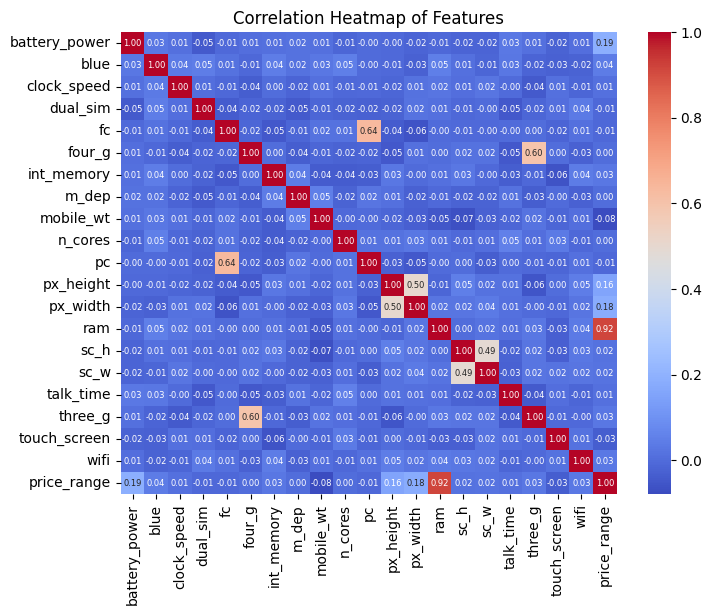

In [12]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 6})
plt.title('Correlation Heatmap of Features')
plt.show()

In [13]:
#Now, drop the column of fc that have strong correlation with pc
df_new = df

In [14]:
#use this code to drop the column
# features = df_new.drop(target_feature, axis=1)
# target = df_new[target_feature]
X_train = df_new.drop(target_feature, axis=1)
y_train = df_new[target_feature]

In [15]:
# Split the data into training and test sets, in a 80:20 ratio
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=20)

#read the valid data
df_valid = pd.read_csv('data_validation.csv')

X_test = df_valid.drop(target_feature, axis=1)
y_test = df_valid[target_feature]

## Building Model

In [16]:
# Dictionary to Show Accuration
accuracy_scores = {}
methods = [
    "KNN SKLearn",
    "KNN",
    "Naive Bayes SKLearn (GaussianNB)",
    "Naive Bayes Categorical",
    "Naive Bayes Discretization",
    "Naive Bayes Gaussian",
    "Naive Bayes Kernel Density Estimation",
]

### K-Nearest Neighbor

scikit-learn

In [17]:
knn_scikit = KNeighborsClassifier(n_neighbors=20)

In [18]:
knn_scikit.fit(X_train, y_train)
y_pred = knn_scikit.predict(X_test)

#print("Predicted label:", y_pred)
accuracy = accuracy_score(y_test, y_pred)
accuracy_scores[methods[0]] = accuracy
print("Accuracy:", accuracy)
print("")
print(classification_report(y_test, y_pred))

c:\Users\seres\miniconda3\envs\pollux\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.93

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       142
           1       0.90      0.91      0.91       144
           2       0.89      0.92      0.90       155
           3       0.99      0.92      0.95       159

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



In [19]:
# Create a Confusion Matrix
matrix = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
        index=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
matrix

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,139,3,0,0
Actual 1,9,131,4,0
Actual 2,0,11,142,2
Actual 3,0,0,13,146


lib "homemade"

In [20]:
# Initialize and train the KNN model
knn = KNN(k=20)
#knn = KNeighborsClassifier(n_neighbors=375)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

#print("Predicted label:", y_pred)
accuracy = accuracy_score(y_test, y_pred)
accuracy_scores[methods[1]] = accuracy
print("Accuracy:", accuracy)
print("")
print(classification_report(y_test, y_pred))

Accuracy: 0.93

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       142
           1       0.90      0.91      0.91       144
           2       0.89      0.92      0.90       155
           3       0.99      0.92      0.95       159

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



##### Confusion Matrix

In [21]:
# Create a Confusion Matrix
matrix = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
        index=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
matrix

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,139,3,0,0
Actual 1,9,131,4,0
Actual 2,0,11,142,2
Actual 3,0,0,13,146


### Naive Bayes

#### SKLearn

In [22]:
# Build and fit the model
clf = GaussianNB()
clf.fit(X_train, y_train)

c:\Users\seres\miniconda3\envs\pollux\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [23]:
# Making predictions
pred = clf.predict(X_test)

In [24]:
# Measuring the accuracy of the model
acc = accuracy_score(y_test, pred)
accuracy_scores[methods[2]] = acc
print("Accuracy:", acc)
print("")
print(classification_report(y_test, pred))

Accuracy: 0.7783333333333333

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       142
           1       0.66      0.64      0.65       144
           2       0.68      0.71      0.70       155
           3       0.90      0.89      0.90       159

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



##### Confusion Matrix

In [25]:
# Create a Confusion Matrix
matrix = pd.DataFrame(
        confusion_matrix(y_test, pred),
        columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
        index=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
matrix

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,124,18,0,0
Actual 1,19,92,33,0
Actual 2,0,30,110,15
Actual 3,0,0,18,141


#### Homemade from "lib"

##### split categorical and numerical indexes - perform discretization

In [26]:
# Categorical features
categorical_index = []
for i in categorical_features:
    categorical_index.append(df.columns.get_loc(i))

# Numerical features
numerical_index = []
for i in numerical_features:
    numerical_index.append(df.columns.get_loc(i))

model = NaiveBayes(categorical_features=categorical_index, numerical_features=numerical_index, alpha=0.5, scott_rule=True)

In [27]:
model.fit(X_train, y_train)

fitting NaiveBayes


In [28]:
#predict the test data
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
accuracy_scores[methods[3]] = acc
print("Accuracy:", acc)
print("")
print(classification_report(y_test, y_pred))

Accuracy: 0.7283333333333334

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       142
           1       0.62      0.65      0.63       144
           2       0.59      0.63      0.61       155
           3       0.83      0.82      0.83       159

    accuracy                           0.73       600
   macro avg       0.74      0.73      0.73       600
weighted avg       0.74      0.73      0.73       600



##### Confusion Matrix

In [29]:
# Create a Confusion Matrix
matrix = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
        index=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
matrix

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,115,21,4,2
Actual 1,12,93,38,1
Actual 2,0,34,98,23
Actual 3,0,2,26,131


##### Naive Bayes - perform discretization (all non-target features is numerical)

In [30]:
model2 = NaiveBayes(alpha=0.1, scott_rule=True)

In [31]:
model2.fit(X_train, y_train)
#predict the test data
y_pred = model2.predict(X_test)
acc = accuracy_score(y_test, y_pred)
accuracy_scores[methods[4]] = acc
print("Accuracy:", acc)
print("")
print(classification_report(y_test, y_pred))

fitting NaiveBayes
Accuracy: 0.72

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       142
           1       0.62      0.64      0.63       144
           2       0.58      0.61      0.59       155
           3       0.82      0.81      0.82       159

    accuracy                           0.72       600
   macro avg       0.73      0.72      0.72       600
weighted avg       0.73      0.72      0.72       600



#### Gaussian Naive Bayes

In [32]:
modelgnb = GaussianNaiveBayes(numerical_features=numerical_index, alpha=0.5)
modelgnb.fit(X_train, y_train)
y_pred = modelgnb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
accuracy_scores[methods[5]] = acc
print("Accuracy:", acc)
print("")
print(classification_report(y_test, y_pred))

Accuracy: 0.7783333333333333

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       142
           1       0.66      0.64      0.65       144
           2       0.68      0.71      0.70       155
           3       0.90      0.89      0.90       159

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



##### Confusion Matrix

In [33]:
# Create a Confusion Matrix
matrix = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
        index=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
matrix

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,124,18,0,0
Actual 1,19,92,33,0
Actual 2,0,30,110,15
Actual 3,0,0,18,141


#### Naive Bayes with Kernel Density Method

In [34]:
predictor = NaiveBayes(alpha=0.5, kernel=True)

In [35]:
predictor.fit(X_train, y_train)

fitting NaiveBayes


In [36]:
y_pred = predictor.predict(X_test)


In [37]:
acc = accuracy_score(y_test, y_pred)
accuracy_scores[methods[6]] = acc
print("Accuracy:", acc)
print("")
print(classification_report(y_test, y_pred))

Accuracy: 0.7766666666666666

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       142
           1       0.65      0.71      0.68       144
           2       0.68      0.66      0.67       155
           3       0.91      0.85      0.88       159

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



##### Confusion Matrix

In [38]:
matrix = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
        index=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
matrix

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,126,16,0,0
Actual 1,17,102,25,0
Actual 2,0,38,103,14
Actual 3,0,0,24,135


## Conclusion

In [39]:
# Create a DataFrame to display accuracy scores in a table
accuracy_df = pd.DataFrame.from_dict(accuracy_scores, orient='index', columns=['Accuracy'])
accuracy_df.index.name = 'Feature Selection Method'

accuracy_df

,Accuracy
Feature Selection Method,
KNN SKLearn,0.930000
KNN,0.930000
Naive Bayes SKLearn (GaussianNB),0.778333
Naive Bayes Categorical,0.728333
Naive Bayes Discretization,0.720000
Naive Bayes Gaussian,0.778333
Naive Bayes Kernel Density Estimation,0.776667


## Save the model

In [40]:
import pickle

In [41]:
#export knn model with pickle
pickle.dump(knn, open('model/knn_model.pkl', 'wb'))

#export naive bayes gaussian model with pickle
pickle.dump(modelgnb, open('model/naive_bayes_gasussian_model.pkl', 'wb'))

#export naive bayes kernel density method model with pickle
pickle.dump(predictor, open('model/naive_bayes_kde_model.pkl', 'wb'))


In [42]:
#try repredict with knn model
knn_model = pickle.load(open('model/knn_model.pkl', 'rb'))
y_pred = knn_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


Accuracy: 0.93


In [44]:
gaussian_model = pickle.load(open('model/naive_bayes_gasussian_model.pkl', 'rb'))
y_pred = gaussian_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7783333333333333


In [45]:
kde_model = pickle.load(open('model/naive_bayes_kde_model.pkl', 'rb'))
y_pred = kde_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


Accuracy: 0.7766666666666666
